# Implementation Tests and Demonstrations for Pyro GP Module: 1D test functions, Gaussian likelihood and RBF kernel

This notebook tests different implementations for the Gaussian processess framework implementation in [`pyro.contrib.gp`](https://github.com/pyro-ppl/pyro/tree/dev/pyro/contrib/gp) module


In [167]:
!pip install -q pyro-ppl

In [168]:
import os
import matplotlib.pyplot as plt
import torch
import numpy as np


import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist

from mpl_toolkits.axes_grid1 import make_axes_locatable

import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


smoke_test = "CI" in os.environ  # ignore; used to check code integrity in the Pyro repo
assert pyro.__version__.startswith('1.8.6')
pyro.set_rng_seed(0)
torch.set_default_tensor_type(torch.DoubleTensor)

# Data Generation

## 1. 1-D Test Functions

We generate the different 1-D data points from a various test functions.
The test function is specifed in the dictionary and the parameters to specify are:
 * `start`: the lower bound of the interval from which we sample the x-axis grid   
 * `end`: the upper bound of the interval from which we sample the x-axis grid
 * `num_of_points`: num of equidistant points to cover the x-axis grid
 * `num_of_points_tes`: num of equdistant points for the x-axis grid in which we evaluate the predicted function
 * `padding`: length of the intraval added to lower and upper bound to extend the train x-axis grid, its used for testing and measuring the ability of the model to extrapolate outside the training regions  


In [169]:
# define function in the torch specific way
fcn1 = lambda x: 0.5 * torch.sin(3 * x)
fcn2 = lambda x: torch.pow((6 * x - 2),2)* torch.sin(2 * (6 * x - 2))
fcn3 = lambda x: torch.Tensor(x) * torch.sin(x)

fcn_dict = {
    # label, [start, end, num_of_points, num_of_points_test, padding for test region ], fcn
    'fcn1': ["$f(x) = 0.5 \sin(3x)$", [0, 5, 20, 500, 0.5], fcn1],
    'fcn2': ["$f(x) = (6x - 2)^2 \sin[2(6x - 2)]$", [0, 1, 30, 500, 0.5], fcn2],
    'fcn3': ["$f(x) = x \sin(x)$", [0, 10, 1000, 500, 0.5], fcn3]
    }

In [170]:
# set hyperparameters for data generation

fcn_key_ = 'fcn1' # select function
noise_std = 0.2 # add noise to experiment with perturbations of the input data
N = 20 # number of training data points

__Generated variables__

*   variable X is x-axis grid over which the values of the function f(x) are being computed  
*   variable y correspond to f(x) values
* (X_train, y_train) is uniformly subsampled N points used for training
* (X_train, y_train_noise) is uniformly subsampled N points used for training with mixed in Gaussian noise with variance specified in variable noise_std
* X_test is x-grid which has extra padding on both side outside the train interval to test the ability of the model to extrapolate
* (X_test, y_test) fucntion f(x) computed on the testing interval X_test



In [171]:
# generate data
# get grid
X = np.linspace(
    start=fcn_dict[fcn_key_][1][0],
    stop=fcn_dict[fcn_key_][1][1],
    num=fcn_dict[fcn_key_][1][2]).reshape(-1, 1)

# apply selected function
temp_y = fcn_dict[fcn_key_][2](torch.Tensor(X))
y = np.squeeze(temp_y.numpy())

# sample training set
X_train = dist.Uniform(fcn_dict[fcn_key_][1][0], fcn_dict[fcn_key_][1][1]).sample(sample_shape=(N,))
y_train = fcn_dict[fcn_key_][2](torch.Tensor(X_train))
# mix in normal noise
y_train_noisy = y_train + dist.Normal(0.0, noise_std).sample(sample_shape=(N,))

X_test = np.squeeze(np.linspace(
    start=fcn_dict[fcn_key_][1][0] - fcn_dict[fcn_key_][1][4],
    stop=fcn_dict[fcn_key_][1][1] + fcn_dict[fcn_key_][1][4],
    num=fcn_dict[fcn_key_][1][3]))

temp_y_test = fcn_dict[fcn_key_][2](torch.Tensor(X_test))
y_test = np.squeeze(temp_y_test.numpy())

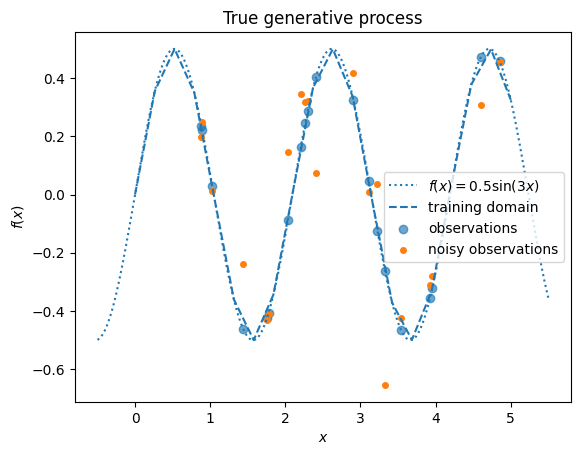

In [172]:
plt.plot(X_test, y_test, label=fcn_dict[fcn_key_][0], linestyle="dotted")
plt.plot(X, y, label='training domain', linestyle="dashed", color=sns.color_palette()[0])
plt.scatter(X_train, y_train, label="observations",  alpha=0.65, color=sns.color_palette()[0])
plt.scatter(X_train, y_train_noisy, label="noisy observations", s=16, color=sns.color_palette()[1])
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("True generative process")

# Pyro Gaussian Processes Module
The [contributed GP module](https://docs.pyro.ai/en/latest/contrib.gp.html#models) contains the following functinality:
- Gaussian Process Regression --> cubic computational complexity in size of the inputs on train and test time
- Sparse Gaussian Process Regression --> partially reduces the computational complexity
- Variational Gaussian Process
- Variational Sparse Gaussian Processs
- Gaussian Process Latent Model --> the train input data is a latent variable

The key inputs are:
1. training data
2. [kernel](https://docs.pyro.ai/en/latest/contrib.gp.html#module-pyro.contrib.gp.kernels)
3. likelihood / loss function specification
4. optimisation

In [173]:
def visualise_training(losses, variances, lengthscales, noises):
  fig, ax = plt.subplots(1, 4, figsize=(15, 3))
  ax[0].plot(losses)
  ax[0].set_title('loss')
  ax[1].plot(variances)
  ax[1].set_title('variance')
  ax[2].plot(lengthscales)
  ax[2].set_title('lengthscales')
  ax[3].plot(noises)
  ax[3].set_title('noise parameter')

def mse(predicted, labels):
    res = torch.mean((predicted - labels) ** 2)
    return res

def rmse(predicted, labels):
    res = torch.sqrt(mse(predicted, labels))
    return res

def visualise_results(model, grid=X_train, labels=y_train, title_=' '):
  with torch.no_grad():
    mean, cov = model.forward(torch.Tensor(X_test), full_cov=True)
    mean_train, cov_train = model.forward(torch.Tensor(X_train), full_cov=True)
  sd = cov.diag().sqrt().numpy()
  rmse_train = rmse(mean_train, torch.Tensor(y_train)).numpy()
  rmse_test = rmse(mean, torch.Tensor(y_test)).numpy()

  title_ = '{}\nrmse train: {: .4f}, rmse test: {: .4f}'.format(title_, rmse_train, rmse_test)
  plt.plot(X_test, y_test, label=fcn_dict[fcn_key_][0], linestyle="dotted")
  plt.scatter(X_train, y_train, label="Observations")
  plt.plot(X_test, mean.numpy(), label="Mean prediction")
  plt.fill_between(
      X_test.ravel(),
      mean.numpy() - 1.96 * sd,
      mean.numpy() + 1.96 * sd,
      alpha=0.3,
      label=r"95% confidence interval",
  )
  plt.legend()
  plt.xlabel("$x$")
  plt.ylabel("$f(x)$")
  _ = plt.title(title_)
  plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

def plot_loss(loss):
    plt.plot(loss)
    plt.xlabel("Iterations")
    _ = plt.ylabel("Loss")  # supress output text


def  is_var(model):
  if type(model) == gp.models.VariationalSparseGP or type(model) == gp.models.VariationalGP:
    res = True
  else:
    res = False
  return res


def visualise_trajectories(model, fcn_key_, samples):
  num_test_grid = fcn_dict[fcn_key_][1][3]
  noise = (model.likelihood.variance if is_var(model) else model.noise)
  cov = kernel.forward(torch.Tensor(X_test)) + noise.expand(num_test_grid).diag()
  samples = dist.MultivariateNormal(
              torch.zeros(num_test_grid), covariance_matrix=cov).sample(sample_shape=(samples,))
  fig, ax = plt.subplots(figsize=(8, 3))
  _ = ax.plot(X_test, samples.T, lw=2, alpha=0.4)
  _ = plt.title('variance: {: .4f}, lengthscale: {: .4f}'.format(model.kernel.variance.item(), model.kernel.lengthscale.item()))

## 1. GP Regression

* support various kernels and can be combined with custom kernels e.g. deep kernels
* does not support custom likelihood

### Implementation 1
* manually define the optimisation steps and uses pytorch Adam optimiser
* MLE - Gaussian likelihood

In [174]:
# set parameters for RBF kernel
var_ = 6.
lengthscale_ = 0.05

# set kernel
kernel = gp.kernels.RBF(
    input_dim=1,
    variance=torch.tensor(var_),
    lengthscale=torch.tensor(lengthscale_))

# initiate model
gpr = gp.models.GPRegression(torch.Tensor(X_train), torch.Tensor(y_train), kernel)

In [175]:
hex(id(kernel)), hex(id(gpr))

('0x7940e61b5ab0', '0x7940e5448e20')

In [176]:
pyro.clear_param_store() # clears parameters stored in the model

optimizer = torch.optim.Adam(gpr.parameters(), lr=0.005)
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss

losses = []
variances = []
lengthscales = []
noises = []

num_steps = 2000
for i in range(num_steps):
    variances.append(gpr.kernel.variance.item())
    noises.append(gpr.noise.item())
    lengthscales.append(gpr.kernel.lengthscale.item())
    # --- optimisation of the variational inference
    optimizer.zero_grad()
    loss = loss_fn(gpr.model, gpr.guide) # model p(x,z) and guide q(z) = posterior approximation
    loss.backward()
    optimizer.step()
    # ---
    losses.append(loss.item())

In [177]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name).data.cpu().numpy())

kernel.lengthscale 0.771487497262315
kernel.variance 0.4967294317797537
noise 2.47821040410252e-05


In [178]:
gpr.kernel.variance.item(), gpr.kernel.lengthscale.item(), gpr.noise.item()

(0.4967294317797537, 0.771487497262315, 2.47821040410252e-05)

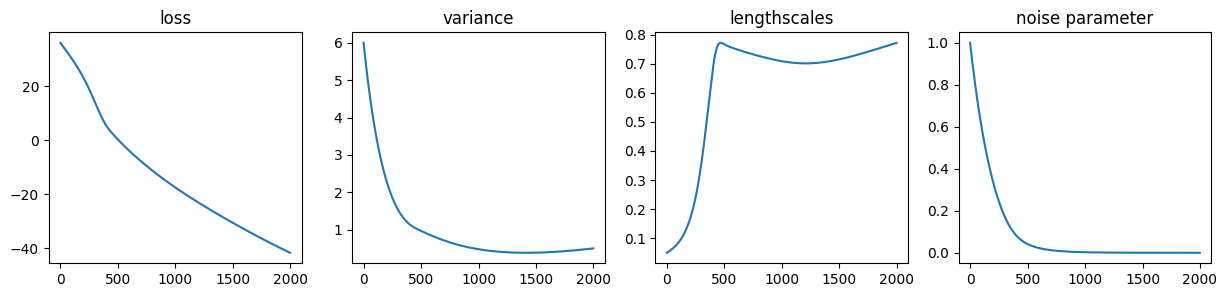

In [179]:
visualise_training(losses, variances, lengthscales, noises)

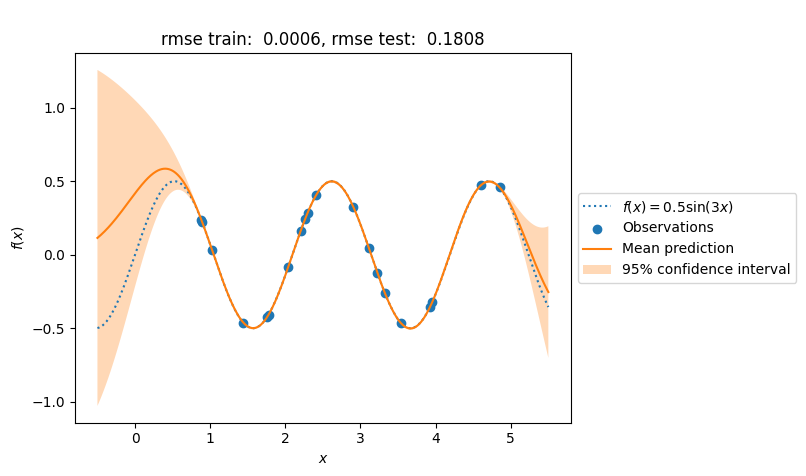

In [180]:
visualise_results(gpr)

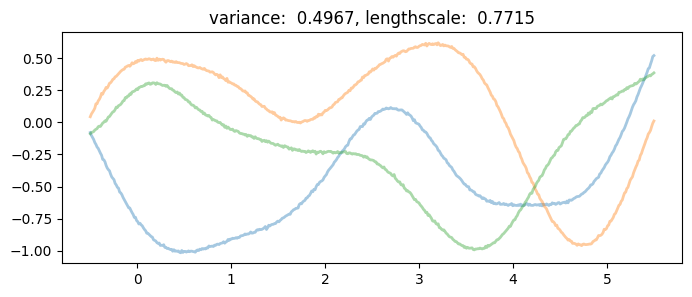

In [247]:
visualise_trajectories(gpr, fcn_key_, 3)

### Implementation 2

* uses SVI wrapper pyro's version of Adam optimiser
* MLE - Gaussian likelihood

In [181]:
# set parameters for RBF kernel
var_ = 6.
lengthscale_ = 0.05

# set kernel
kernel2 = gp.kernels.RBF(
    input_dim=1,
    variance=torch.tensor(var_),
    lengthscale=torch.tensor(lengthscale_))

# initiate model
gpr2 = gp.models.GPRegression(torch.Tensor(X_train), torch.Tensor(y_train), kernel2)

In [182]:
hex(id(kernel2)), hex(id(gpr2))

('0x7940e643ebc0', '0x7940e643e7d0')

In [248]:
pyro.clear_param_store() # clears parameters stored in the model

optimizer2 = pyro.optim.Adam({"lr": 0.005, "betas": (0.90, 0.999)})
loss_fn2 = pyro.infer.Trace_ELBO()

svi = pyro.infer.SVI(gpr2.model, gpr2.guide, optimizer2, loss=loss_fn2)

losses2 = []
variances2 = []
lengthscales2 = []
noises2 = []

num_steps = 2000
for i in range(num_steps):
    variances2.append(gpr2.kernel.variance.item())
    noises2.append(gpr2.noise.item())
    lengthscales2.append(gpr2.kernel.lengthscale.item())
    loss = svi.step()
    losses2.append(loss)

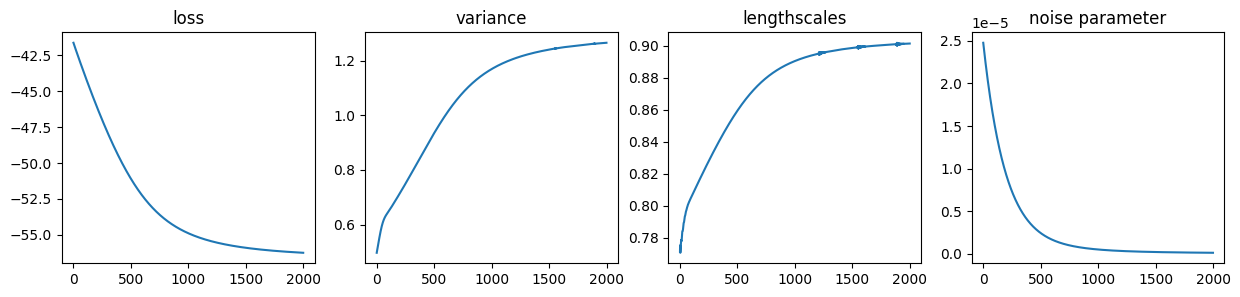

In [249]:
visualise_training(losses2, variances2, lengthscales2, noises2)

In [250]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name).data.cpu().numpy())

kernel.lengthscale 0.9012927674032586
kernel.variance 1.264957645744282
noise 9.318776181572654e-08


In [186]:
gpr2.kernel.variance.item(), gpr2.kernel.lengthscale.item(), gpr2.noise.item()

(0.4967294317797537, 0.771487497262315, 2.47821040410252e-05)

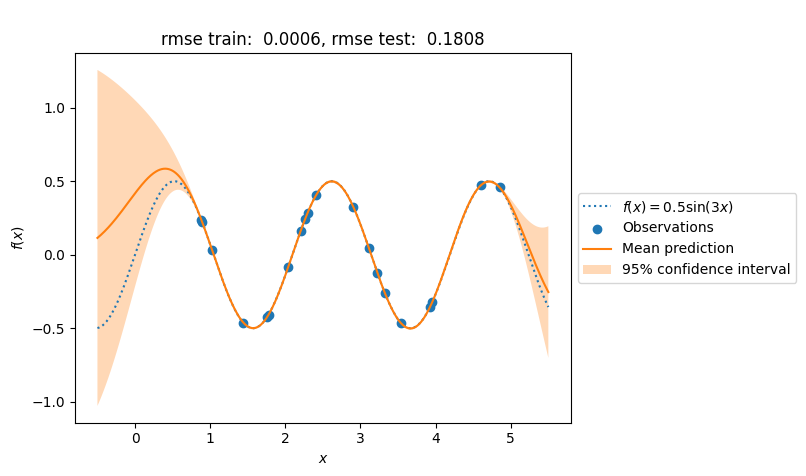

In [187]:
visualise_results(gpr2)

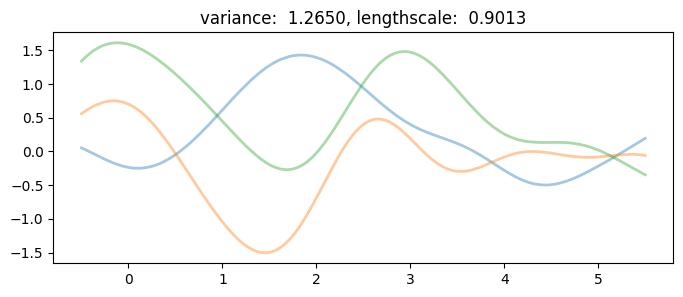

In [251]:
visualise_trajectories(gpr2, fcn_key_, 3)

### Implementation 3

* optimise using MAP

In [189]:
def optimise(model, num_steps = 2000, lr_=0.005):
  pyro.clear_param_store()
  optimizer = torch.optim.Adam(model.parameters(), lr=lr_)
  loss_fn = pyro.infer.Trace_ELBO().differentiable_loss

  losses = []
  variances = []
  lengthscales = []
  noises = []

  pbar = tqdm.tqdm(range(num_steps), position=0, leave=True)

  for epoch in pbar:
      variances.append(model.kernel.variance.item())
      noises.append(model.noise.item())
      lengthscales.append(model.kernel.lengthscale.item())

      optimizer.zero_grad()
      loss = loss_fn(model.model, model.guide)
      loss.backward()
      optimizer.step()

      losses.append(loss.item())

  model.set_mode("guide")
  print("\nvariance = {: .6f}".format(model.kernel.variance))
  print("lengthscale = {: .6f}".format(model.kernel.lengthscale))
  print("noise = {: .6f}".format(model.noise))
  res = {'model': model,
          'losses' : losses,
          'variances' : variances,
          'lengthscales' : lengthscales,
          'noises' : noises}
  return res

In [190]:
kernel_map = gp.kernels.RBF(
    input_dim=1, variance=torch.tensor(5.0), lengthscale=torch.tensor(10.0)
)
gpr_map = gp.models.GPRegression(torch.Tensor(X_train), torch.Tensor(y_train), kernel_map, noise=torch.tensor(1.0))

# define priors
gpr_map.kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(0.0, 1.0))
gpr_map.kernel.variance = pyro.nn.PyroSample(dist.LogNormal(0.0, 1.0))

In [191]:
gpr_map_res = optimise(gpr_map)

100%|██████████| 2000/2000 [00:13<00:00, 145.46it/s]


variance =  0.402437
lengthscale =  0.728631
noise =  0.000101


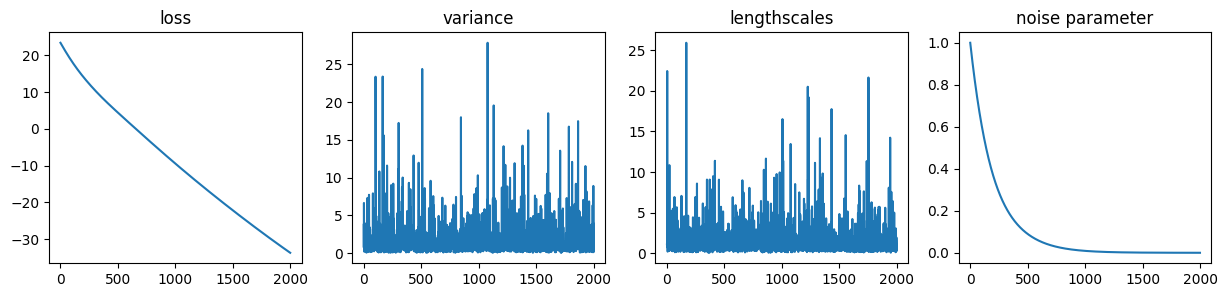

In [192]:
visualise_training(gpr_map_res['losses'], gpr_map_res['variances'], gpr_map_res['lengthscales'], gpr_map_res['noises'])

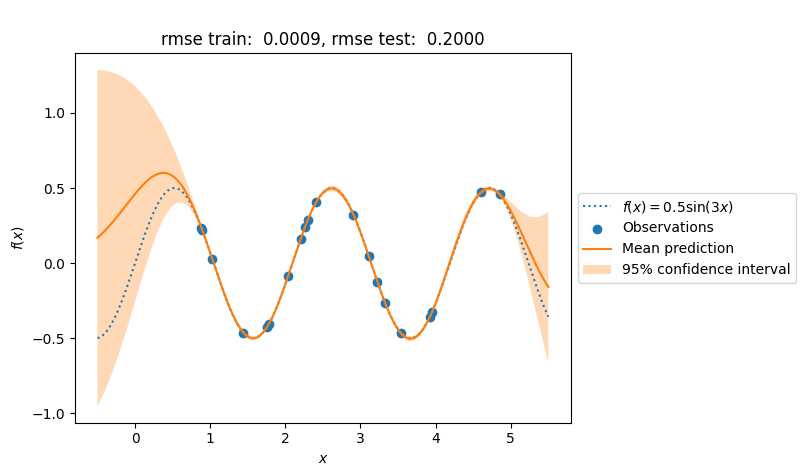

In [193]:
visualise_results(gpr_map)

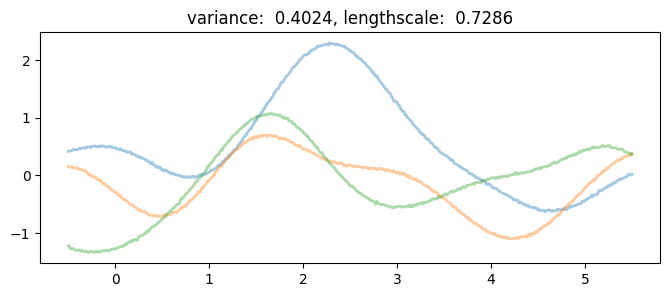

In [252]:
visualise_trajectories(gpr_map, fcn_key_, 3)

### Perturbing the training data with the Gaussian noise

In [194]:
# mixed-in noise
kernel3 = gp.kernels.RBF(
    input_dim=1, variance=torch.tensor(var_), lengthscale=torch.tensor(lengthscale_))
gpr_noise = gp.models.GPRegression(torch.Tensor(X_train), torch.Tensor(y_train_noisy), kernel3)

In [195]:
gpr_noise_res = optimise(gpr_noise)

100%|██████████| 2000/2000 [00:10<00:00, 186.25it/s]


variance =  0.093098
lengthscale =  0.237331
noise =  0.017328


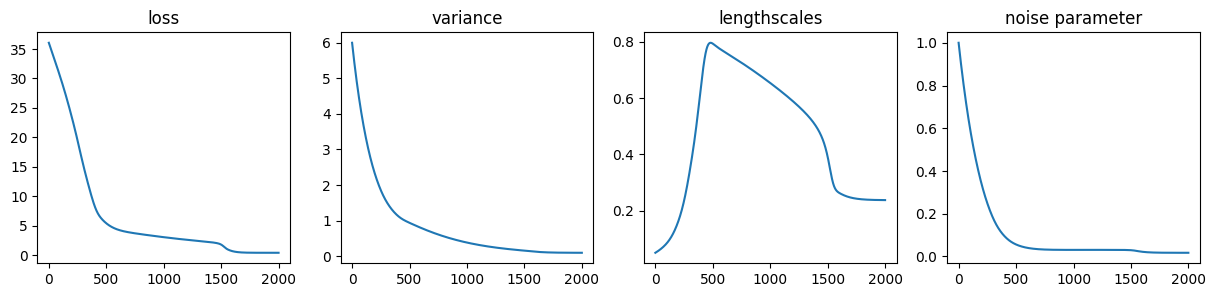

In [196]:
visualise_training(gpr_noise_res['losses'], gpr_noise_res['variances'], gpr_noise_res['lengthscales'], gpr_noise_res['noises'])

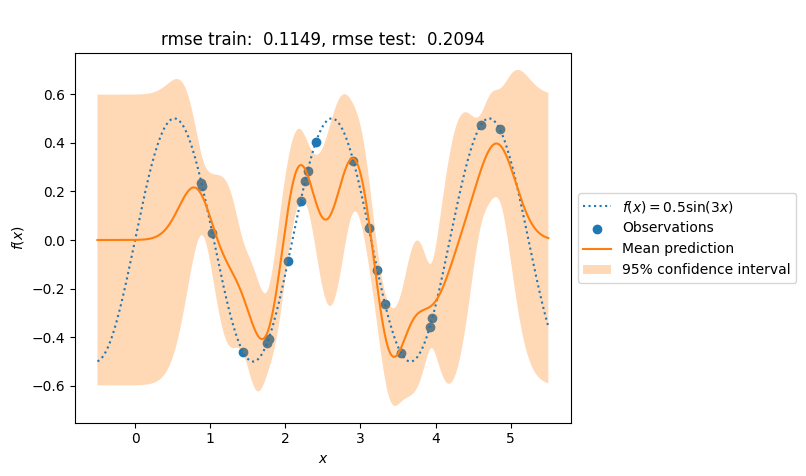

In [197]:
visualise_results(gpr_noise)

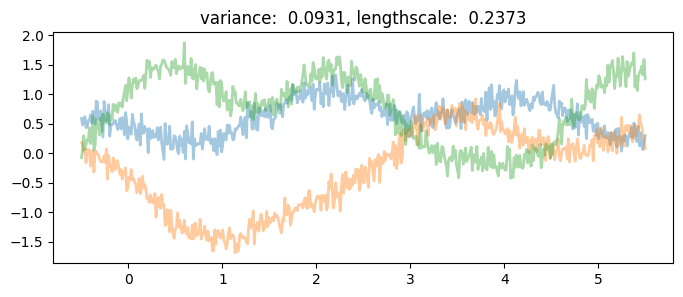

In [253]:
visualise_trajectories(gpr_noise, fcn_key_, 3)

## Sparse Gaussian Process Processs

In [198]:
import torch
from torch.distributions import constraints
from torch.nn import Parameter
from torch import nn

import pyro
import pyro.distributions as dist
from pyro.nn.module import PyroParam, pyro_method
from pyro.contrib.gp.models import VariationalGP, SparseGPRegression
from pyro.contrib.gp.util import conditional
from pyro.distributions.util import eye_like

In [199]:
var_ = 6.
lengthscale_ = 0.05

# initialize the inducing inputs
Nu = 10
Xu = np.linspace(
    start=fcn_dict[fcn_key_][1][0],
    stop=fcn_dict[fcn_key_][1][1],
    num=Nu).reshape(-1, 1)

kernel4 = gp.kernels.RBF(
    input_dim=1, variance=torch.tensor(var_), lengthscale=torch.tensor(lengthscale_))
sgpr1 = gp.models.SparseGPRegression(torch.Tensor(X_train), torch.Tensor(y_train), kernel4, torch.Tensor(Xu))

sgpr1_res = optimise(sgpr1)

100%|██████████| 2000/2000 [00:19<00:00, 104.00it/s]


variance =  0.421533
lengthscale =  0.708864
noise =  0.000932


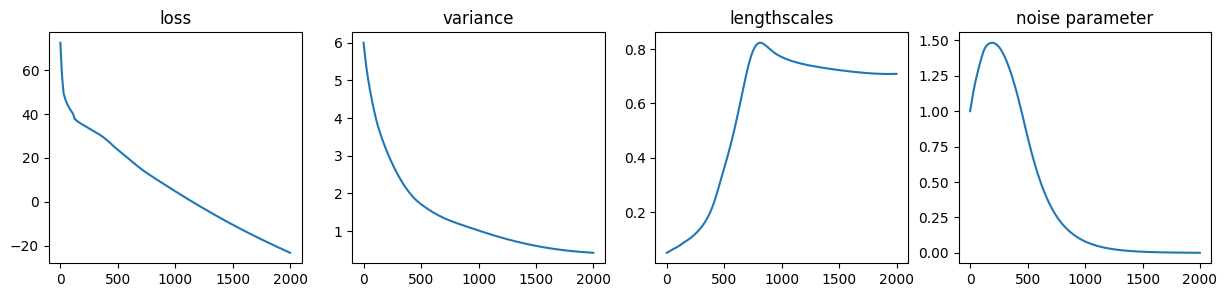

In [200]:
visualise_training(sgpr1_res['losses'], sgpr1_res['variances'], sgpr1_res['lengthscales'], sgpr1_res['noises'])

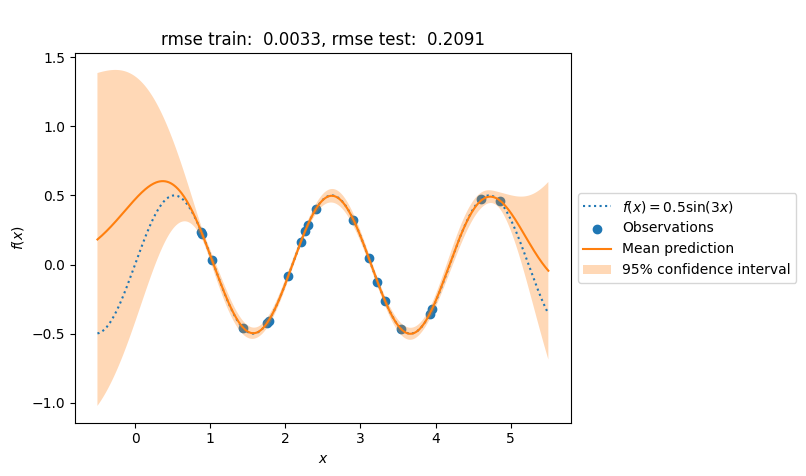

In [201]:
visualise_results(sgpr1)

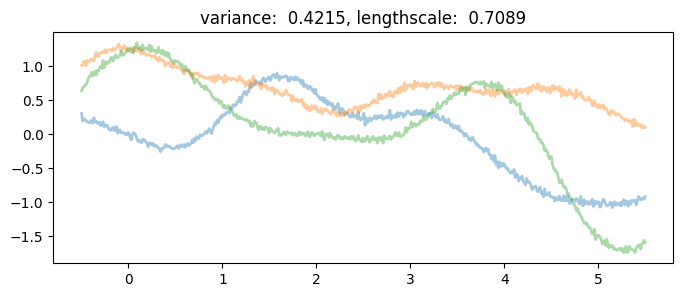

In [254]:
visualise_trajectories(sgpr1, fcn_key_, 3)

## Variational Gaussian Process Regressor

In [202]:
from pyro.contrib.gp.likelihoods.likelihood import Likelihood
from pyro.nn.module import PyroParam, pyro_method

class Gaussian(Likelihood):
    def __init__(self, variance=None):
        super().__init__()

        variance = torch.tensor(1.) if variance is None else variance
        self.variance = PyroParam(variance, constraints.positive)

    def forward(self, f_loc, f_var, y=None):
        y_dist = dist.Normal(f_loc + torch.randn(f_loc.dim(), device=f_loc.device)*f_var, self.variance.sqrt())
        self.y_dist = y_dist
        if y is not None:
            y_dist = y_dist.expand_by(y.shape[:-f_loc.dim()]).to_event(y.dim())
        return pyro.sample(self._pyro_get_fullname("y"), y_dist, obs=y)

### Gaussian likelihood - own implementation

In [203]:
# set parameters for RBF kernel
var_ = 6.
lengthscale_ = 0.05

In [204]:
likelihood = Gaussian()

kernel5 = gp.kernels.RBF(
    input_dim=1,
    variance=torch.tensor(var_),
    lengthscale=torch.tensor(lengthscale_))

# own implemented Gaussian likelihood
vgp1 = VariationalGP(X=X_train, y=y_train, kernel=kernel5, likelihood=likelihood, whiten=True, jitter=1e-06)

In [205]:
pyro.clear_param_store()

num_steps = 2000
losses = gp.util.train(vgp1, num_steps=num_steps)

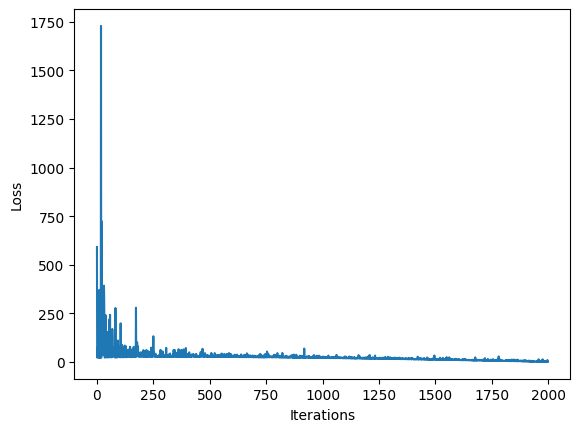

In [206]:
plot_loss(losses)

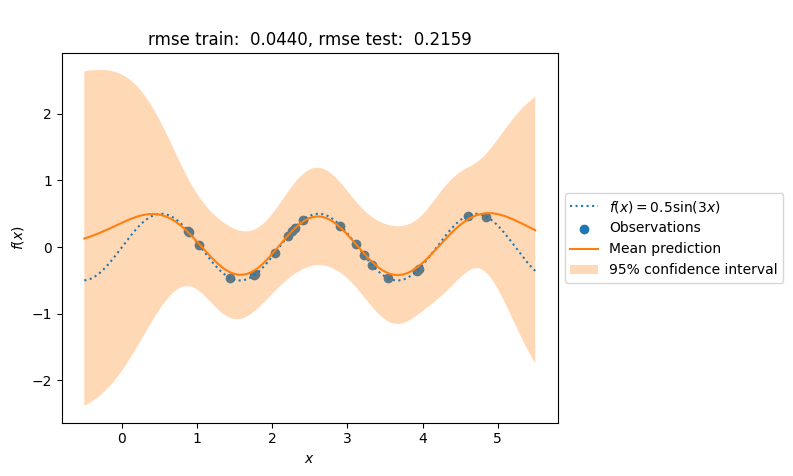

In [207]:
visualise_results(vgp1)

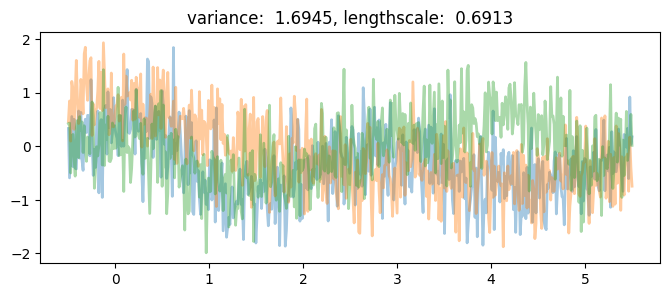

In [256]:
visualise_trajectories(vgp1, fcn_key_, 3)

### Gaussian likelihood - contributed implementation

In [208]:
likelihood2 = gp.likelihoods.Gaussian()

kernel6 = gp.kernels.RBF(
    input_dim=1,
    variance=torch.tensor(var_),
    lengthscale=torch.tensor(lengthscale_))

# pyro contrib implemented Gaussian likelihood
vgp2 = VariationalGP(X=X_train, y=y_train, kernel=kernel6, likelihood=likelihood2, whiten=True, jitter=1e-06)

In [209]:
pyro.clear_param_store()

num_steps = 2000
losses = gp.util.train(vgp2, num_steps=num_steps)

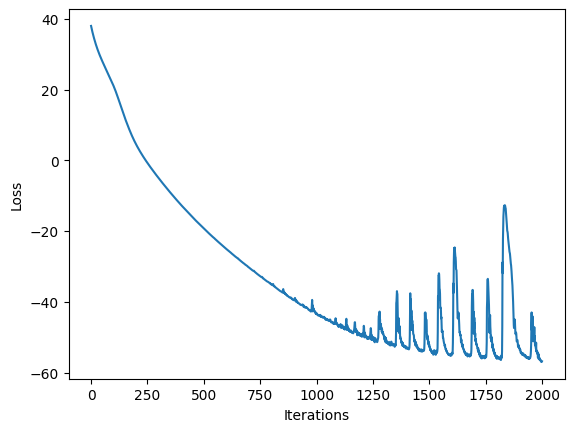

In [210]:
plot_loss(losses)

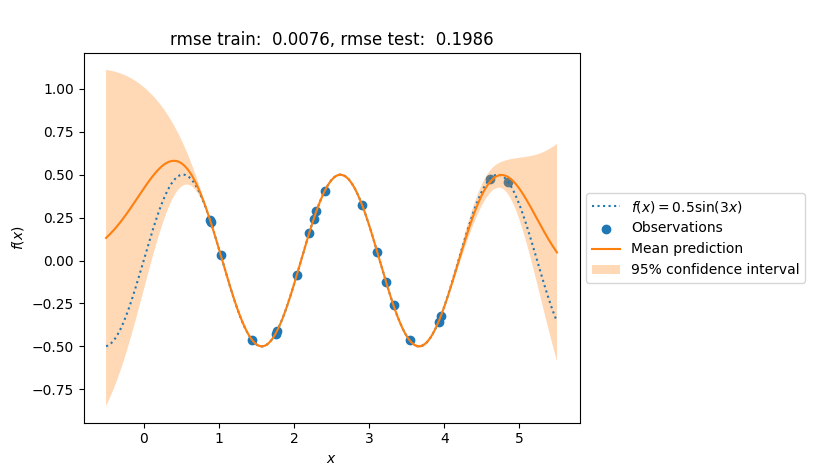

In [211]:
visualise_results(vgp2)

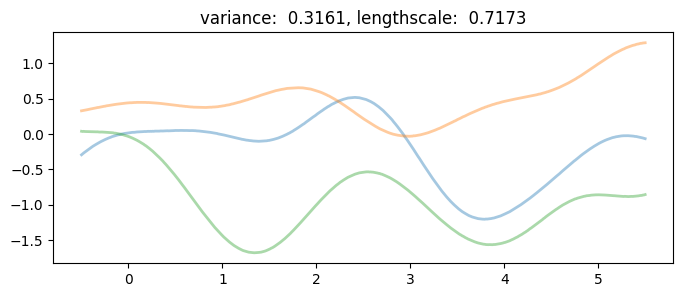

In [257]:
visualise_trajectories(vgp2, fcn_key_, 3)

### Gaussian likelihood - different optimisation

In [212]:
kernel7 = gp.kernels.RBF(
    input_dim=1,
    variance=torch.tensor(var_),
    lengthscale=torch.tensor(lengthscale_))
vgp3 = VariationalGP(X=X_train, y=y_train, kernel=kernel7, likelihood=likelihood, whiten=True, jitter=1e-06)

In [213]:
import tqdm

pyro.clear_param_store()

epochs = 2000
pbar = tqdm.tqdm(range(epochs), position=0, leave=True)

optimizer = torch.optim.Adam(vgp3.parameters(), lr=0.005)
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss

losses = []
variances = []
lengthscales = []
noises = []

for epoch in pbar:
    variances.append(vgp3.kernel.variance.item())
    lengthscales.append(vgp3.kernel.lengthscale.item())
    noises.append(vgp3.likelihood.variance.item())
    optimizer.zero_grad()
    loss = loss_fn(vgp3.model, vgp3.guide)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

100%|██████████| 2000/2000 [00:18<00:00, 108.29it/s]


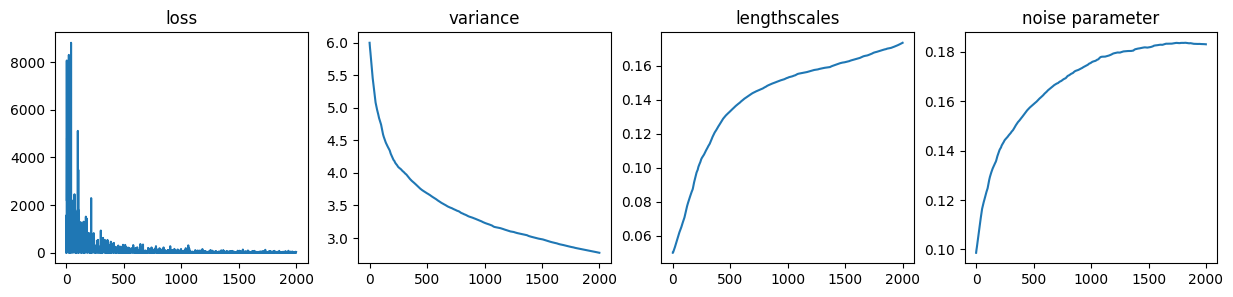

In [214]:
visualise_training(losses, variances, lengthscales, noises)

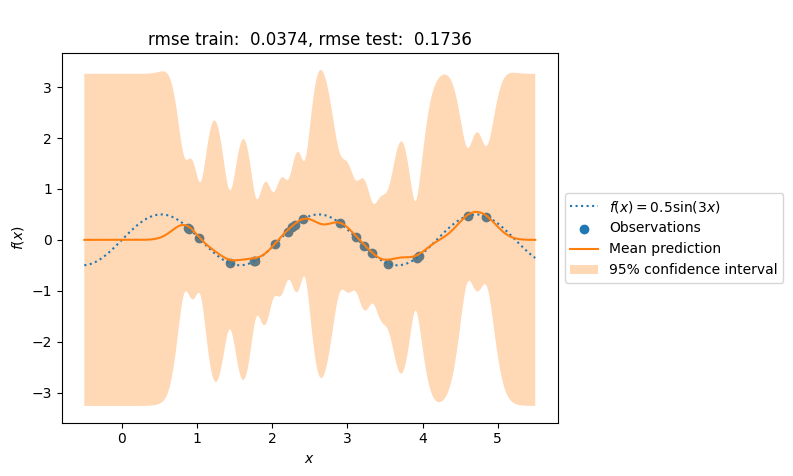

In [215]:
visualise_results(vgp3)

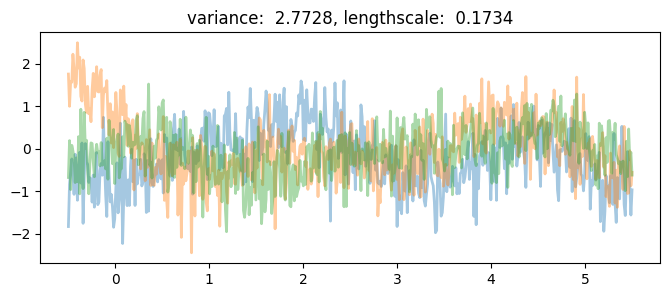

In [258]:
visualise_trajectories(vgp3, fcn_key_, 3)

## Variational Sparse Gaussian Process Regressor

In [216]:
def optimise(model, num_steps = 2000, lr_=0.005, var_gp=False):
  pyro.clear_param_store()
  optimizer = torch.optim.Adam(model.parameters(), lr=lr_)
  loss_fn = pyro.infer.Trace_ELBO().differentiable_loss

  losses = []
  variances = []
  lengthscales = []
  noises = []

  pbar = tqdm.tqdm(range(num_steps), position=0, leave=True)

  for epoch in pbar:
      variances.append(model.kernel.variance.item())
      lengthscales.append(model.kernel.lengthscale.item())
      if var_gp==True:
        noises.append(model.likelihood.variance.item())
      else:
        noises.append(model.noise.item())

      optimizer.zero_grad()
      loss = loss_fn(model.model, model.guide)
      loss.backward()
      optimizer.step()

      losses.append(loss.item())

  model.set_mode("guide")
  print("\nvariance = {: .6f}".format(model.kernel.variance))
  print("lengthscale = {: .6f}".format(model.kernel.lengthscale))
  if var_gp==True:
    print("noise = {: .6f}".format(model.likelihood.variance))
  else:
    print("noise = {: .6f}".format(model.noise))
  res = {'model': model,
          'losses' : losses,
          'variances' : variances,
          'lengthscales' : lengthscales,
          'noises' : noises}
  return res

In [217]:
kernel8 = gp.kernels.RBF(
    input_dim=1,
    variance=torch.tensor(var_),
    lengthscale=torch.tensor(lengthscale_))

Nu = 10
Xu = np.linspace(
    start=fcn_dict[fcn_key_][1][0],
    stop=fcn_dict[fcn_key_][1][1],
    num=Nu).reshape(-1, 1)

vgp4 = gp.models.VariationalSparseGP(X=X_train, y=y_train, kernel=kernel8, likelihood=likelihood, Xu=torch.Tensor(Xu), whiten=True, jitter=1e-06)

In [218]:
vgp4_res = optimise(vgp4, var_gp=True)

100%|██████████| 2000/2000 [00:23<00:00, 86.54it/s]


variance =  3.170814
lengthscale =  0.634114
noise =  0.283903


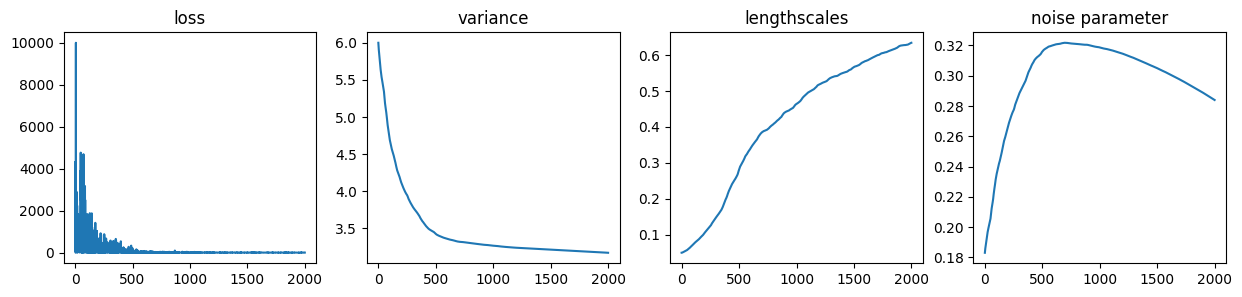

In [219]:
visualise_training(vgp4_res['losses'], vgp4_res['variances'], vgp4_res['lengthscales'], vgp4_res['noises'])

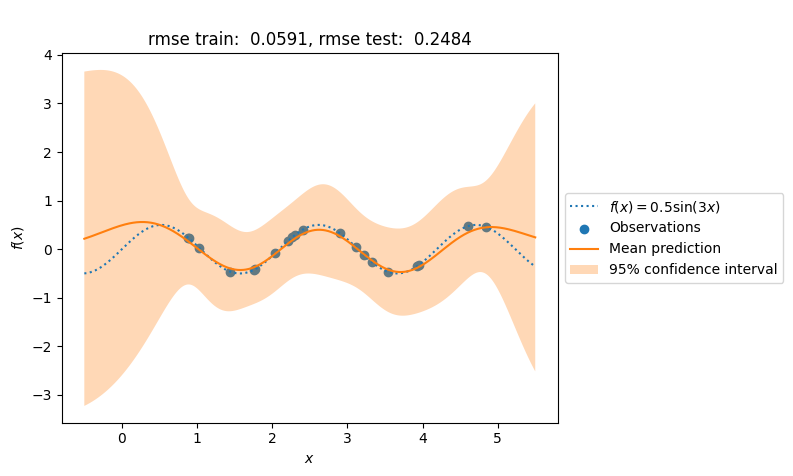

In [220]:
visualise_results(vgp4)

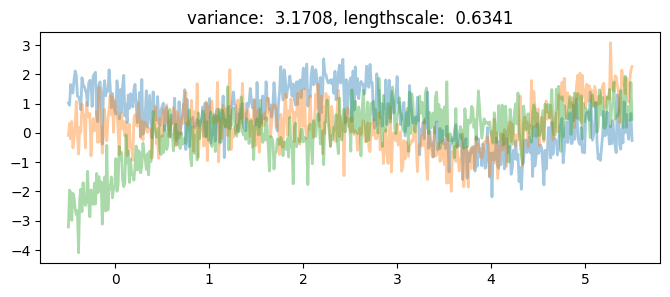

In [259]:
visualise_trajectories(vgp4, fcn_key_, 3)